In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
all_pitches.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,inning_top_bot,pitchHand_code,pitchHand_des,pitch_type,...,strike_left,strike_down_right,strike_down,strike_down_left,call_B,call_C,call_F,call_H,call_S,is_out
0,413661,L,Left,Matt Carpenter,572761,Called Strike,top,L,Left,FF,...,0,0,0,0,0,1,0,0,0,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,top,L,Left,FF,...,0,0,0,0,0,0,0,0,1,0
2,413661,L,Left,Matt Carpenter,572761,Foul,top,L,Left,FF,...,0,0,0,0,0,0,1,0,0,0
3,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,FF,...,0,0,0,0,1,0,0,0,0,0
4,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,CU,...,0,0,0,0,1,0,0,0,0,0


In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

## ``is_out``, No Player ID's

This first iteration of the model will use generic player and pitch information to predict outs. The percentage of pitches that resulted in an out calculated in the ``calls_pct`` table is around 17.36% so I'll be basing the models performance on this statistic. In other words, if the model were to predict no outs for all pitches, it'll have an accuracy of around 82.64% which doesn't provide any insight.

### Simple Model

In [6]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left'].drop(['pitch_locx', 'pitch_locy'], axis=1)

In [7]:
# Extract target variable
targets = calls['is_out']

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    targets, 
                                                    test_size = 0.25, 
                                                    stratify = targets,
                                                    random_state = 123)

In [9]:
base_checkpoint_path = 'base_training/cp.ckpt'
base_checkpoint_dir = os.path.dirname(base_checkpoint_path)

# Create checkpoint callback
base_cp_callback = tf.keras.callbacks.ModelCheckpoint(base_checkpoint_path,
                                                    save_weights_only = True,
                                                    verbose=1)

In [10]:
# Instatiate a Sequential model
model_base = Sequential()

# Create a basic network
model_base.add(Dense(40, activation = 'relu', input_shape = (X_train.shape[1],)))
model_base.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [11]:
# Set up early stopping monitor
early_stopping_monitor = EarlyStopping(patience=3)

In [12]:
# fit the training data to the basic model
base_history = model_base.fit(X_train,
                              y_train,
                              validation_split = 0.25,
                              epochs = 20,
                              callbacks = [early_stopping_monitor, base_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.4022 - acc: 0.8233 - val_loss: 0.3904 - val_acc: 0.8257

Epoch 00001: saving model to base_training/cp.ckpt
Epoch 2/20
1197789/1197789 [==============================] - 26s 22us/step - loss: 0.3947 - acc: 0.8237 - val_loss: 0.3877 - val_acc: 0.8278

Epoch 00002: saving model to base_training/cp.ckpt
Epoch 3/20
1197789/1197789 [==============================] - 26s 22us/step - loss: 0.3924 - acc: 0.8245 - val_loss: 0.3878 - val_acc: 0.8278

Epoch 00003: saving model to base_training/cp.ckpt
Epoch 4/20
1197789/1197789 [==============================] - 26s 22us/step - loss: 0.3913 - acc: 0.8250 - val_loss: 0.3888 - val_acc: 0.8277

Epoch 00004: saving model to base_training/cp.ckpt
Epoch 5/20
1197789/1197789 [==============================] - 26s 22us/step - loss: 0.3907 - acc: 0.8247 - val_loss: 0.3856 - val_acc: 0.8275

Epoch 00005: saving model to

In [13]:
# Save the model
model_base.save('model_base.h5')

# Load model to prevent re-fitting
model_base = keras.models.load_model('model_base.h5')

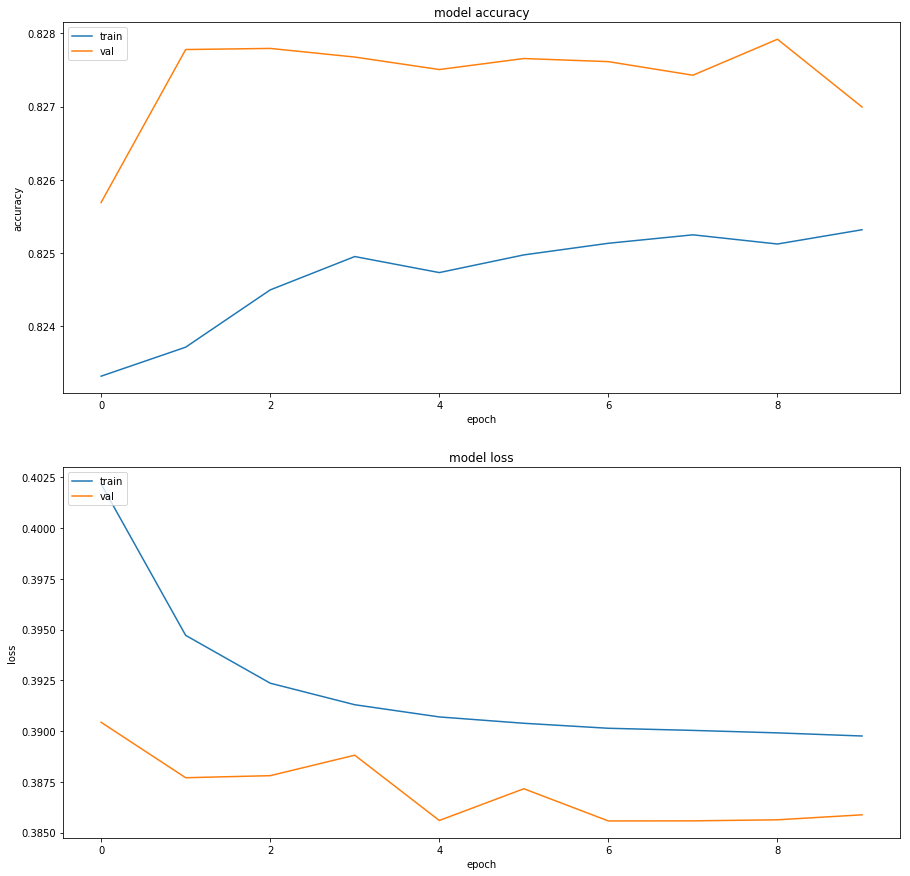

In [14]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(base_history.history['acc'])
_ = plt.plot(base_history.history['val_acc'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(base_history.history['loss'])
_ = plt.plot(base_history.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

In [15]:
# Make predictions on the test set
base_score, base_acc = model_base.evaluate(X_test, y_test)
print('Test score:', base_score)
print('Test accuracy:', base_acc)

532351/532351 [==============================] - 5s 10us/step
Test score: 0.3894753721396481
Test accuracy: 0.8244579234362763


In [16]:
# Make predictions on the test data
base_predictions = model_base.predict_classes(X_test).ravel()

# Print the confusion matrix
confusion_matrix(y_test, base_predictions)

array([[424890,  15027],
       [ 78423,  14011]], dtype=int64)

In [17]:
base_fpr, base_tpr, base_thresholds = roc_curve(y_test, base_predictions)
base_auc= auc(base_fpr, base_tpr)

print(base_auc)

0.5587098536102545


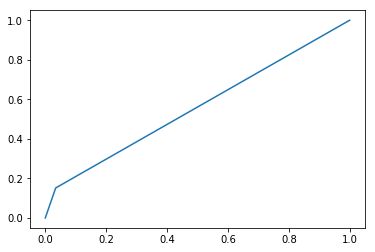

In [18]:
plt.plot(base_fpr, base_tpr)

This simple model was able to accurately predict outs roughly 82.42% of the time on the test set. That may seem like a promising result but if the model were to predict only no outs, it would perform the same. It's also worth noting the models true-positive rate is almost nonexistent.

### Increase Model Capacity

In [19]:
# Instatiate a Sequential model
model_deeper = Sequential()

# Create a 3 layers
model_deeper.add(Dense(300, activation = 'relu', input_shape = (X_train.shape[1],)))
model_deeper.add(Dense(100, activation = 'relu'))
model_deeper.add(Dense(100, activation = 'relu'))
model_deeper.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_deeper.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [20]:
deeper_checkpoint_path = 'deeper_training/cp.ckpt'
deeper_checkpoint_dir = os.path.dirname(deeper_checkpoint_path)

# Create checkpoint callback
deeper_cp_callback = tf.keras.callbacks.ModelCheckpoint(deeper_checkpoint_path,
                                                        save_weights_only = True,
                                                        verbose=1)

In [21]:
# fit the training data to the basic model
deeper_history = model_deeper.fit(X_train,
                                  y_train,
                                  validation_split = 0.25,
                                  epochs = 20,
                                  callbacks = [early_stopping_monitor, deeper_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 54s 45us/step - loss: 0.3969 - acc: 0.8255 - val_loss: 0.3867 - val_acc: 0.8276

Epoch 00001: saving model to deeper_training/cp.ckpt
Epoch 2/20
1197789/1197789 [==============================] - 54s 45us/step - loss: 0.3915 - acc: 0.8256 - val_loss: 0.3948 - val_acc: 0.8279

Epoch 00002: saving model to deeper_training/cp.ckpt
Epoch 3/20
1197789/1197789 [==============================] - 62s 52us/step - loss: 0.3903 - acc: 0.8257 - val_loss: 0.3866 - val_acc: 0.8270

Epoch 00003: saving model to deeper_training/cp.ckpt
Epoch 4/20
1197789/1197789 [==============================] - 57s 47us/step - loss: 0.3897 - acc: 0.8258 - val_loss: 0.3850 - val_acc: 0.8276

Epoch 00004: saving model to deeper_training/cp.ckpt
Epoch 5/20
1197789/1197789 [==============================] - 55s 46us/step - loss: 0.3891 - acc: 0.8259 - val_loss: 0.3848 - val_acc: 0.8276

Epoch 00005: saving 

In [22]:
# Save the model
model_deeper.save('model_deeper.h5')

# Load model to prevent re-fitting
model_deeper = keras.models.load_model('model_deeper.h5')

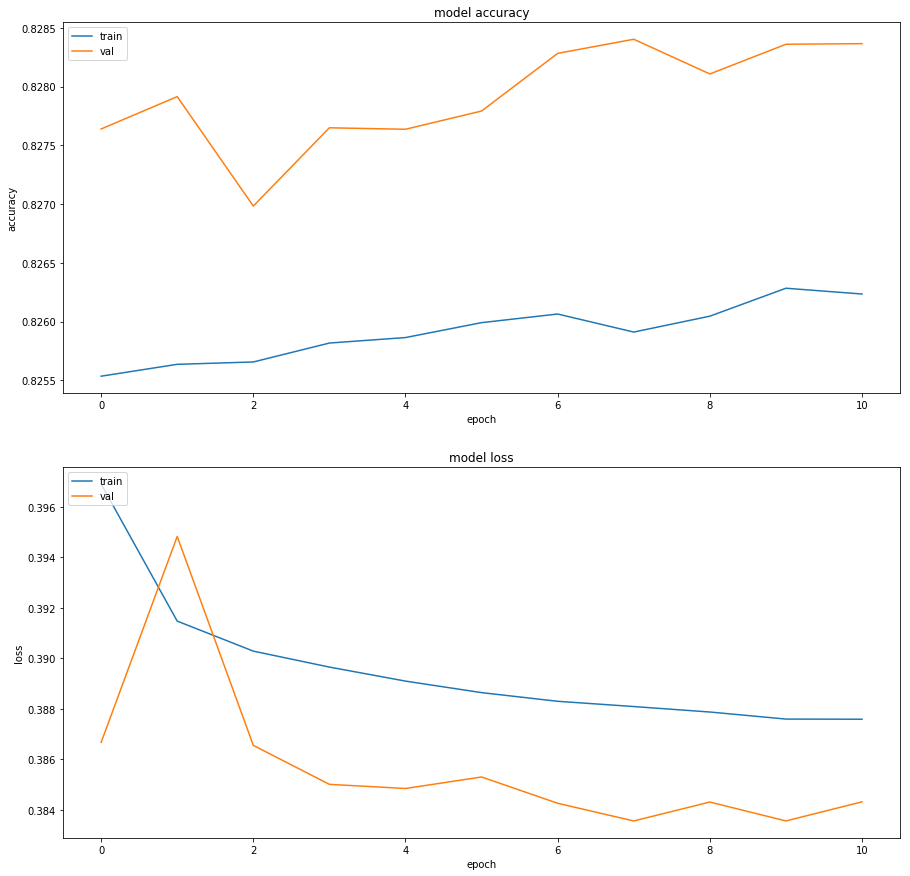

In [23]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(deeper_history.history['acc'])
_ = plt.plot(deeper_history.history['val_acc'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(deeper_history.history['loss'])
_ = plt.plot(deeper_history.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

In [24]:
# Make predictions on the test set
deeper_score, deeper_acc = model_deeper.evaluate(X_test, y_test)
print('Test score:', deeper_score)
print('Test accuracy:', deeper_acc)

532351/532351 [==============================] - 8s 14us/step
Test score: 0.3880151883362351
Test accuracy: 0.8267327383628073


In [25]:
# Make predictions on the test data
deeper_predictions = model_deeper.predict_classes(X_test)

# Print the confusion matrix
confusion_matrix(y_test, deeper_predictions)

array([[436215,   3702],
       [ 88537,   3897]], dtype=int64)

In [26]:
deeper_fpr, deeper_tpr, deeper_thresholds = roc_curve(y_test, deeper_predictions)
deeper_auc = auc(deeper_fpr, deeper_tpr)

print(deeper_auc)

0.5168722937719938


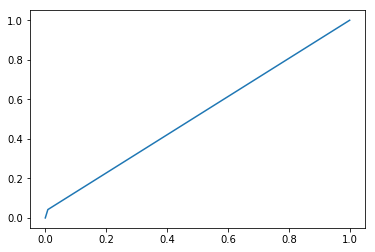

In [27]:
plt.plot(deeper_fpr, deeper_tpr)

Increasing the model capacity improved model performance. Not only is it more accurate the the baseline model, but it also has a much better true-positive rate.

This model still needs improvement but next will be to add different predictors and target variables to the model to see how models improve.

## Calls, No Player ID's

Predictors stay the same but target labels change.

In [28]:
# Split the data into train and test sets
X_call_train, X_call_test, y_call_train, y_call_test = train_test_split(predictors,
                                                                        calls, 
                                                                        test_size = 0.25, 
                                                                        stratify = calls,
                                                                        random_state = 123)

In [29]:
calls_checkpoint_path = 'calls_training/cp.ckpt'
calls_checkpoint_dir = os.path.dirname(calls_checkpoint_path)

# Create checkpoint callback
calls_cp_callback = tf.keras.callbacks.ModelCheckpoint(calls_checkpoint_path,
                                                       save_weights_only = True,
                                                       verbose=1)

In [30]:
# Instatiate a Sequential model
model_calls = Sequential()

# Create a basic network
model_calls.add(Dense(300, activation = 'relu', input_shape = (X_call_train.shape[1],)))
model_calls.add(Dense(100, activation = 'relu'))
model_calls.add(Dense(100, activation = 'relu'))
model_calls.add(Dense(y_call_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_calls.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [31]:
# fit the training data to the basic model
calls_history = model_calls.fit(X_call_train,
                                y_call_train,
                                validation_split = 0.25,
                                epochs = 20,
                                callbacks = [early_stopping_monitor, calls_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 57s 48us/step - loss: 0.3511 - categorical_accuracy: 0.4944 - val_loss: 0.3463 - val_categorical_accuracy: 0.4966

Epoch 00001: saving model to calls_training/cp.ckpt
Epoch 2/20
1197789/1197789 [==============================] - 57s 47us/step - loss: 0.3449 - categorical_accuracy: 0.5009 - val_loss: 0.3435 - val_categorical_accuracy: 0.5068

Epoch 00002: saving model to calls_training/cp.ckpt
Epoch 3/20
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3434 - categorical_accuracy: 0.5029 - val_loss: 0.3441 - val_categorical_accuracy: 0.4987

Epoch 00003: saving model to calls_training/cp.ckpt
Epoch 4/20
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3426 - categorical_accuracy: 0.5048 - val_loss: 0.3430 - val_categorical_accuracy: 0.5054

Epoch 00004: saving model to calls_training/cp.ckpt
Epoch 5/20
1197789/1197789 [===

In [32]:
# Save the model
model_calls.save('model_calls.h5')

# Load model to prevent re-fitting
model_calls = keras.models.load_model('model_calls.h5')

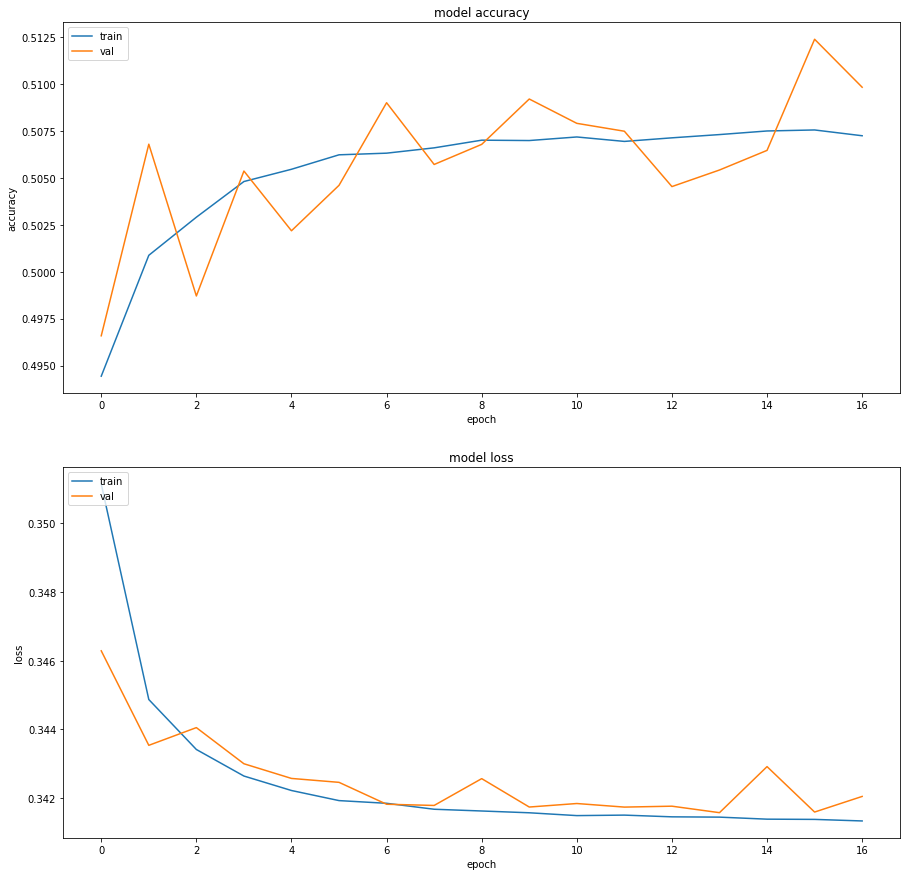

In [37]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(calls_history.history['categorical_accuracy'])
_ = plt.plot(calls_history.history['val_categorical_accuracy'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(calls_history.history['loss'])
_ = plt.plot(calls_history.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

In [38]:
# Make predictions on the test set
calls_score, calls_acc = model_calls.evaluate(X_call_test, y_call_test)
print('Test score:', calls_score)
print('Test accuracy:', calls_acc)

532351/532351 [==============================] - 11s 20us/step
Test score: 0.34163144916616617
Test accuracy: 0.5114595445477198


In [44]:
# Make predictions on the test data
calls_predictions = model_calls.predict(X_call_test)

# print the confusion matrix
calls_matrix = confusion_matrix(y_call_test.values.argmax(axis=1), calls_predictions.argmax(axis=1))
calls_matrix

array([[156477,  21407,   5969,      0,   1478,   6393],
       [  6178,  65746,  10161,      0,   1024,   6547],
       [ 16996,  23659,  30542,      0,   1219,  20157],
       [  3633,  10226,  10646,      0,    504,   9146],
       [ 25740,  11888,  12678,      0,   2072,   8608],
       [  8511,  17863,  18288,      0,   1156,  17439]], dtype=int64)

In [50]:
calls_auc = roc_auc_score(y_call_test, calls_predictions)

print(calls_auc)

0.7878569312099853


In [ ]:
plt.plot(calls_fpr, calls_tpr)

Looking at the confusion matrix, it appears the model wasn't able to pick up which pitches resulted in hits. More capacity may be needed

## ``is_out``, Player ID's

In [51]:
# Extract predictors
predictors_ids = predictors.drop(['pitchHand_isRight', 'batSide_isRight'], axis = 1).join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [52]:
# Split the data into train and test sets
X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(predictors_ids,
                                                                targets, 
                                                                test_size = 0.25, 
                                                                stratify = targets,
                                                                random_state = 123)

In [53]:
scaler = StandardScaler()

X_id_train_scaled = scaler.fit_transform(X_id_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [54]:
X_id_test_scaled = scaler.transform(X_id_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [55]:
ids_checkpoint_path = 'ids_training/cp.ckpt'
ids_checkpoint_dir = os.path.dirname(ids_checkpoint_path)

# Create checkpoint callback
ids_cp_callback = tf.keras.callbacks.ModelCheckpoint(ids_checkpoint_path,
                                                     save_weights_only = True,
                                                     verbose=1)

In [56]:
# Instatiate a Sequential model
model_ids = Sequential()

# Create a 3 layers
model_ids.add(Dense(300, activation = 'relu', input_shape = (X_id_train_scaled.shape[1],)))
model_ids.add(Dense(100, activation = 'relu'))
model_ids.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_ids.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [57]:
# fit the training data to the basic model
ids_history = model_ids.fit(X_id_train_scaled,
                            y_id_train,
                            validation_split = 0.25,
                            epochs = 20,
                            callbacks = [early_stopping_monitor, ids_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 64s 54us/step - loss: 0.3913 - acc: 0.8257 - val_loss: 0.3857 - val_acc: 0.8277

Epoch 00001: saving model to ids_training/cp.ckpt
Epoch 2/20
1197789/1197789 [==============================] - 52s 44us/step - loss: 0.3890 - acc: 0.8257 - val_loss: 0.3849 - val_acc: 0.8280

Epoch 00002: saving model to ids_training/cp.ckpt
Epoch 3/20
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3888 - acc: 0.8257 - val_loss: 0.3849 - val_acc: 0.8277

Epoch 00003: saving model to ids_training/cp.ckpt
Epoch 4/20
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3885 - acc: 0.8257 - val_loss: 0.3848 - val_acc: 0.8278

Epoch 00004: saving model to ids_training/cp.ckpt
Epoch 5/20
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3883 - acc: 0.8259 - val_loss: 0.3848 - val_acc: 0.8261

Epoch 00005: saving model to ids

In [58]:
# Save the model
model_ids.save('model_ids.h5')

# Load model to prevent re-fitting
model_ids = keras.models.load_model('model_ids.h5')

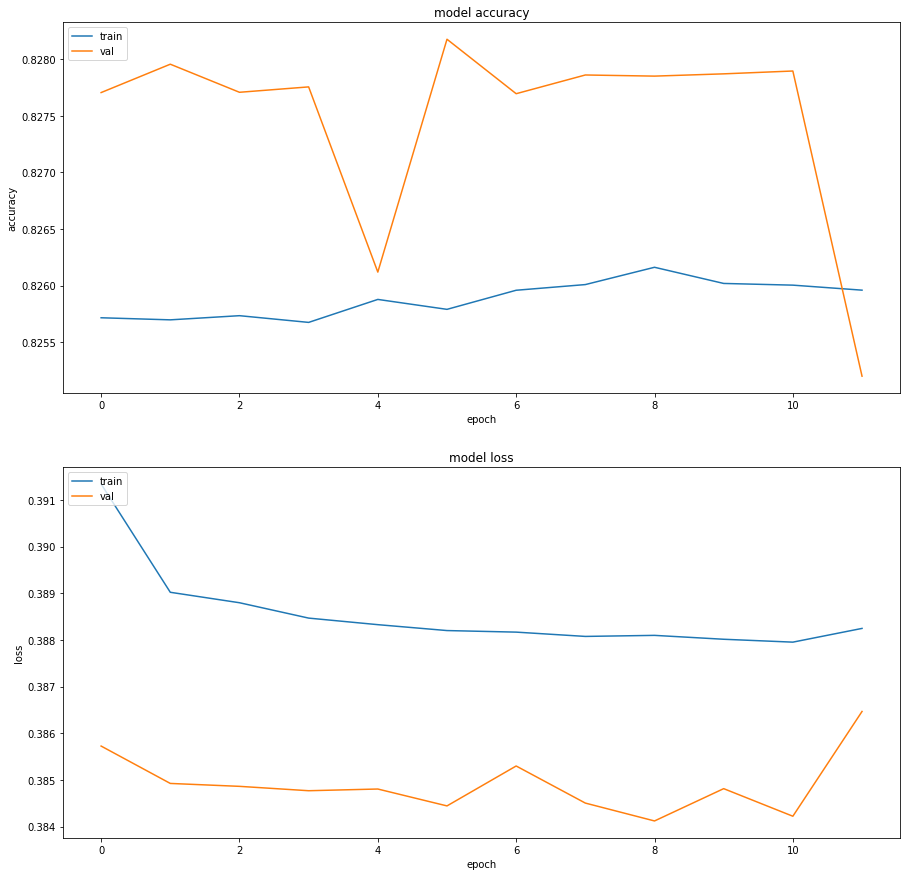

In [59]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(ids_history.history['acc'])
_ = plt.plot(ids_history.history['val_acc'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(ids_history.history['loss'])
_ = plt.plot(ids_history.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

In [60]:
# Make predictions on the test set
ids_score, ids_acc = model_ids.evaluate(X_id_test_scaled, y_id_test)
print('Test score:', ids_score)
print('Test accuracy:', ids_acc)

532351/532351 [==============================] - 12s 22us/step
Test score: 0.3899681961366602
Test accuracy: 0.8227334972588107


In [61]:
# Make predictions on the test data
ids_predictions = model_ids.predict_classes(X_id_test_scaled)

# Print the confusion matrix
confusion_matrix(y_id_test, ids_predictions)

array([[420268,  19649],
       [ 74719,  17715]], dtype=int64)

In [62]:
ids_fpr, ids_tpr, ids_thresholds = roc_curve(y_test, ids_predictions)
ids_auc = auc(ids_fpr, ids_tpr)

print(ids_auc)

0.5734925074459507


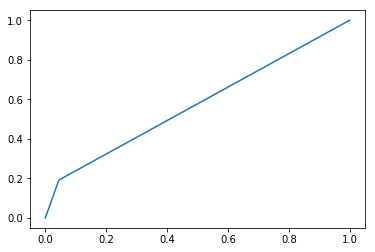

In [63]:
plt.plot(ids_fpr, ids_tpr)

## Calls, Player ID's

In [64]:
# Split the data into train and test sets
X_callids_train, X_callids_test, y_callids_train, y_callids_test = train_test_split(predictors_ids,
                                                                                    calls, 
                                                                                    test_size = 0.25, 
                                                                                    stratify = calls,
                                                                                    random_state = 123)

In [65]:
scaler_calls = StandardScaler()

X_callids_train_scaled = scaler_calls.fit_transform(X_callids_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [66]:
X_callids_test_scaled = scaler_calls.transform(X_callids_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [67]:
callids_checkpoint_path = 'callids_training/cp.ckpt'
callids_checkpoint_dir = os.path.dirname(callids_checkpoint_path)

# Create checkpoint callback
callids_cp_callback = tf.keras.callbacks.ModelCheckpoint(callids_checkpoint_path,
                                                         save_weights_only = True,
                                                         verbose=1)

In [68]:
# Instatiate a Sequential model
model_calls_id = Sequential()

# Create a basic network
model_calls_id.add(Dense(300, activation = 'relu', input_shape = (X_callids_train_scaled.shape[1],)))
model_calls_id.add(Dense(100, activation = 'relu'))
model_calls_id.add(Dense(100, activation = 'relu'))
model_calls_id.add(Dense(y_callids_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_calls_id.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [87]:
# fit the training data to the basic model
callids_history = model_calls_id.fit(X_callids_train_scaled,
                                    y_callids_train,
                                    validation_split = 0.25,
                                    epochs = 20,
                                    callbacks = [early_stopping_monitor])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 65s 54us/step - loss: 0.3541 - categorical_accuracy: 0.5008 - val_loss: 0.3547 - val_categorical_accuracy: 0.4957
Epoch 2/20
1197789/1197789 [==============================] - 63s 53us/step - loss: 0.3540 - categorical_accuracy: 0.5011 - val_loss: 0.3559 - val_categorical_accuracy: 0.4979
Epoch 3/20
1197789/1197789 [==============================] - 63s 53us/step - loss: 0.3525 - categorical_accuracy: 0.5008 - val_loss: 0.3466 - val_categorical_accuracy: 0.5033
Epoch 4/20
1197789/1197789 [==============================] - 64s 54us/step - loss: 0.3534 - categorical_accuracy: 0.5007 - val_loss: 0.3547 - val_categorical_accuracy: 0.5023
Epoch 5/20
1197789/1197789 [==============================] - 64s 54us/step - loss: 0.3540 - categorical_accuracy: 0.5010 - val_loss: 0.3552 - val_categorical_accuracy: 0.5051
Epoch 6/20
1197789/1197789 [==============================] - 67s 5

In [88]:
# Save the model
model_calls_id.save('model_callids.h5')

# Load model to prevent re-fitting
model_calls_id = keras.models.load_model('model_callids.h5')

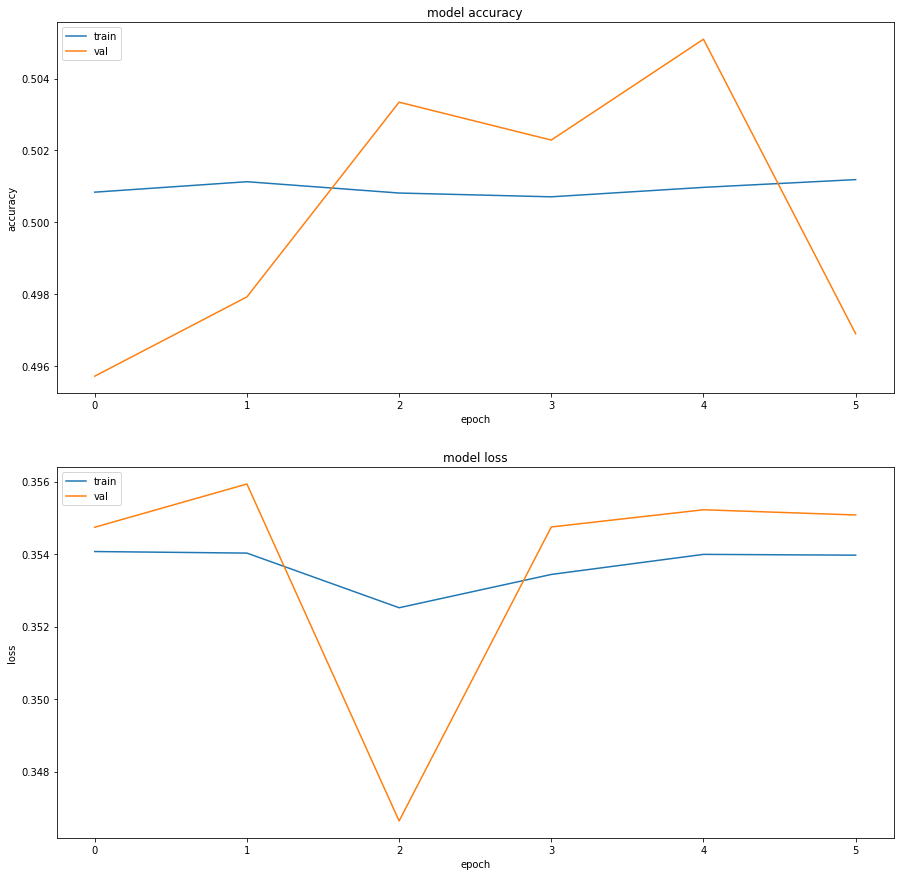

In [89]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(callids_history.history['categorical_accuracy'])
_ = plt.plot(callids_history.history['val_categorical_accuracy'])
_ = plt.title('model accuracy')
_ = plt.ylabel('accuracy')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(callids_history.history['loss'])
_ = plt.plot(callids_history.history['val_loss'])
_ = plt.title('model loss')
_ = plt.ylabel('loss')
_ = plt.xlabel('epoch')
_ = plt.legend(['train', 'val'], loc='upper left')

In [90]:
# Make predictions on the test set
callids_score, callids_acc = model_calls_id.evaluate(X_callids_test_scaled, y_callids_test)
print('Test score:', callids_score)
print('Test accuracy:', callids_acc)

532351/532351 [==============================] - 13s 25us/step
Test score: 0.35405509815476743
Test accuracy: 0.4981393854799044


In [91]:
# Make predictions on the test data
callids_predictions = model_calls_id.predict(X_callids_test_scaled)

In [92]:
callids_matrix = confusion_matrix(y_callids_test.values.argmax(axis=1), callids_predictions.argmax(axis=1))
callids_matrix

array([[157556,  18463,   4989,      0,   1400,   9316],
       [  9300,  61806,   9694,      8,    781,   8067],
       [ 18023,  22768,  22448,     10,   1359,  27965],
       [  4149,   9752,   8160,      9,    500,  11585],
       [ 26333,  11208,   9695,      8,   1994,  11748],
       [  9720,  16874,  14225,     13,   1053,  21372]], dtype=int64)

In [93]:
callids_auc = roc_auc_score(y_callids_test, callids_predictions)

print(callids_auc)

0.7811400484162166


In [ ]:
plt.plot(callids_fpr, callids_tpr)